In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from time import perf_counter

In [2]:
from gradient_growing_trees.tree import GradientGrowingTreeRegressor

In [3]:
def make_comparison(X, y, models, depth_range=(1, 9), n_repeats=20, n_splits=5):
    if y.ndim == 1:
        y = y[:, np.newaxis]
    all_results = dict()

    for depth in range(*depth_range):
        rand_results = defaultdict(dict)
        for name, model_factory in models.items():
            cur_res = []
            cur_times = []
            for s in range(n_repeats):
                kfold = KFold(n_splits=n_splits, shuffle=True, random_state=s)
                for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
                    m = model_factory(depth)
                    before_time = perf_counter()
                    m.fit(X[train_idx], y[train_idx])
                    preds = m.predict(X[test_idx])
                    after_time = perf_counter()
                    score = r2_score(y[test_idx], preds)
                    cur_res.append(score)
                    cur_times.append(after_time - before_time)
            rand_results[name]['R2'] = np.array(cur_res)
            rand_results[name]['time'] = np.array(cur_times)
        all_results[depth] = rand_results

    df_data = defaultdict(list)

    for d, res in all_results.items():
        for name, metric_values in res.items():
            for metric, values in metric_values.items():
                for v in values:
                    df_data['name'].append(name)
                    df_data['depth'].append(d)
                    df_data['metric'].append(metric)
                    df_data['value'].append(v)

    df = pd.DataFrame(df_data)
    return df


In [4]:
from sklearn.datasets import make_friedman3

In [5]:
fm3_X, fm3_y = make_friedman3(n_samples=500, noise=0.15, random_state=12345)

**Here we define a custom loss function**

In this example we define MSE, and then compare it with internal `batch_mse` criterion

In [6]:
def custom_loss(ys, sample_ids, cur_value, g_out, h_out):
    g_out = np.asarray(g_out)
    h_out = np.asarray(h_out)
    sample_ids = np.asarray(sample_ids)
    g_out[sample_ids] = -2.0 * (np.asarray(ys)[sample_ids] - np.asarray(cur_value)[np.newaxis])
    h_out[sample_ids] = 2.0

**Arguments:**

- ys – all target values
- sample_ids – current node sample ids, only for them gradients should be updated
- cur_value – current node value (prediction for all samples in the node)
- g_out – output buffer for the gradients
- h_out – output buffer for the hessian diagonal

In [7]:
models = {
    'CART': lambda d: DecisionTreeRegressor(max_depth=d, min_samples_split=6, min_samples_leaf=3, random_state=1),
    'Extra': lambda d: DecisionTreeRegressor(max_depth=d, splitter='random', min_samples_split=6, min_samples_leaf=3, random_state=1),
    'GGT (l2=0.1, CL)': lambda d: GradientGrowingTreeRegressor(lam_2=0.1, lr=1.0, criterion=custom_loss, splitter='best', max_depth=d, random_state=1),
    'GGT (l2=0.5, CL)': lambda d: GradientGrowingTreeRegressor(lam_2=0.5, lr=1.0, criterion=custom_loss, splitter='best', max_depth=d, random_state=1),
    'GGT (l2=0.1, MSE)': lambda d: GradientGrowingTreeRegressor(lam_2=0.1, lr=1.0, criterion='batch_mse', splitter='best', max_depth=d, random_state=1),
    'GGT (l2=0.5, MSE)': lambda d: GradientGrowingTreeRegressor(lam_2=0.5, lr=1.0, criterion='batch_mse', splitter='best', max_depth=d, random_state=1),
}

In [8]:
df = make_comparison(fm3_X, fm3_y, models, depth_range=(1, 18), n_repeats=4)

In [9]:
t = pd.pivot_table(df.query('metric == "R2"'), values='value', index='depth', columns='name').style.highlight_max(
    axis=1,
    props="font-weight: bold",
).format("{:0.3f}")
t

name,CART,Extra,"GGT (l2=0.1, CL)","GGT (l2=0.1, MSE)","GGT (l2=0.5, CL)","GGT (l2=0.5, MSE)"
depth,,,,,,
1,0.370,0.372,0.336,0.336,0.275,0.275
2,0.499,0.402,0.501,0.501,0.474,0.474
3,0.618,0.498,0.600,0.600,0.589,0.589
4,0.654,0.527,0.647,0.647,0.661,0.661
5,0.671,0.638,0.675,0.675,0.686,0.686
6,0.666,0.645,0.660,0.660,0.687,0.687
7,0.656,0.636,0.657,0.657,0.673,0.673
8,0.643,0.610,0.649,0.649,0.660,0.660
9,0.631,0.610,0.638,0.638,0.650,0.650


We can see from above that the custom loss leads to the same results as `batch_mse`.

Lets compare the Gradient Growing Trees with classical CART trees:

<Axes: xlabel='depth', ylabel='R2'>

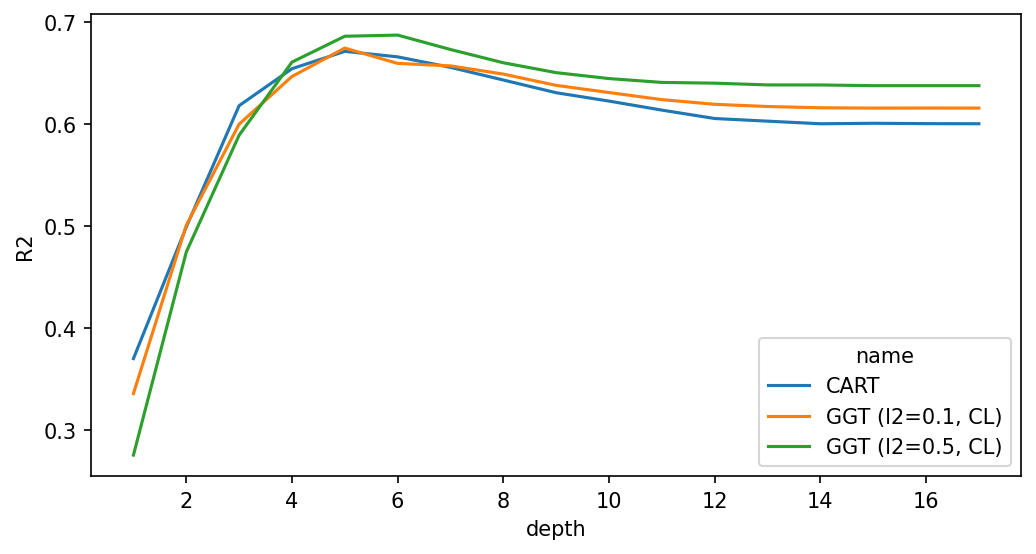

In [10]:
plt.figure(figsize=(8, 4), dpi=150)
sns.lineplot(
    df.query('metric == "R2"').rename({'value': 'R2'}, axis=1).query(
        'name in ["CART", "GGT (l2=0.1, CL)", "GGT (l2=0.5, CL)"]'
    ),
    x='depth', y='R2', hue='name', errorbar=None
)

Calling python function instead of using embedded loss function leads to performance degradation (the same complexity, but larger constant):

<Axes: xlabel='depth', ylabel='time'>

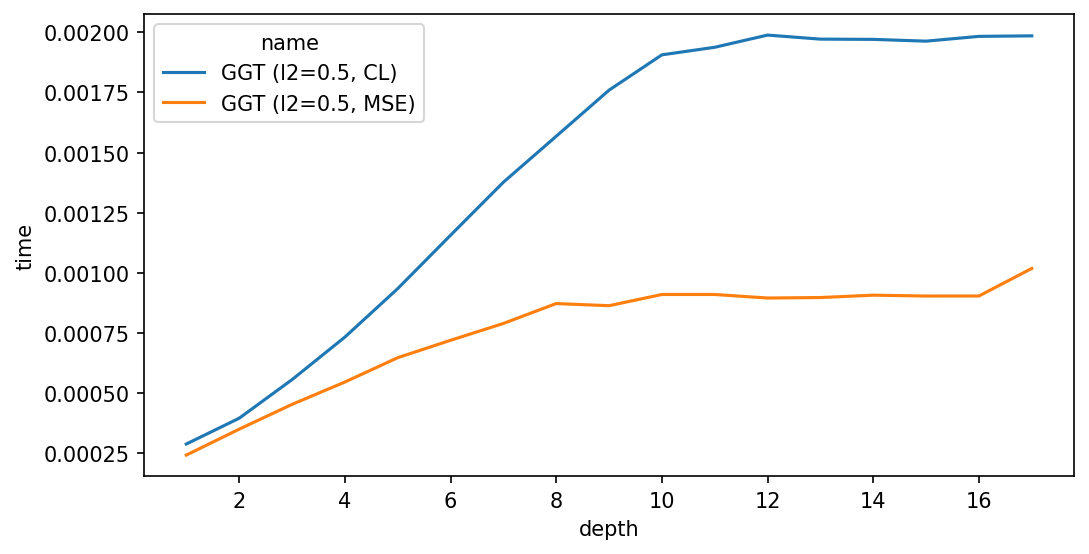

In [11]:
plt.figure(figsize=(8, 4), dpi=150)
sns.lineplot(
    df.query('metric == "time"').rename({'value': 'time'}, axis=1).query(
        'name in ["GGT (l2=0.5, CL)", "GGT (l2=0.5, MSE)"]'
    ),
    x='depth', y='time', hue='name', errorbar=None
)